# ScoreStruct

In **maelzel.core** there is a division of concerns between music data (notes, chords, lines, voices, etc) and a score structure. The score structure (the `ScoreStruct` class) consists of a set of measure definitions (time signature, tempo). 

* [Defining a score structure](#Defining-a-score-structure)
* [Content / Structure](#Content-/-Structure)
* [Creating a click track from a ScoreStruct](#Creating-a-click-track-from-a-ScoreStruct)
* [Exporting](#Exporting)
* [Musical time vs Real time](#Musical-time-vs-Real-time)


In [1]:
from maelzel.core import *
import csoundengine as ce
from maelzel.snd.audiosample import Sample
from IPython.display import display
ce.config['synthgroup_repr_max_rows'] = 0

## Defining a score structure

A `ScoreStruct` can be defined by adding measure definitions or from a string.

Notice at the html representation of the ScoreStruct that there are time signatures which appear between parenthesis: these are inherited time signatures. The same applies to tempo: **if the measure does not define an explicit time signature or tempo, then these attributes are inherited from the previous measure** with an explicit tempo

In [2]:
scorestruct = ScoreStruct(r'''
4/4, 70
5/8
3/4, 140, Section B
3/8
# A first value indicates the measure number. 
# Measures start at 0
10, 4/4, 60  
5/16
.      # a period repeats the last measure
7/16
3/8
# Three periods at the end indicate that this score extends indefinitely
...
''')
scorestruct


Meas. Index,Timesig,Tempo (quarter note),Label,Rehearsal,Barline
0,4/4,70,,,
1,5/8,,,,
2,3/4,140,Section B,,
3,3/8,,,,
4,(3/8),,,,
5,(3/8),,,,
6,(3/8),,,,
7,(3/8),,,,
8,(3/8),,,,
9,(3/8),,,,


A `ScoreStruct` can be displayed as notation:

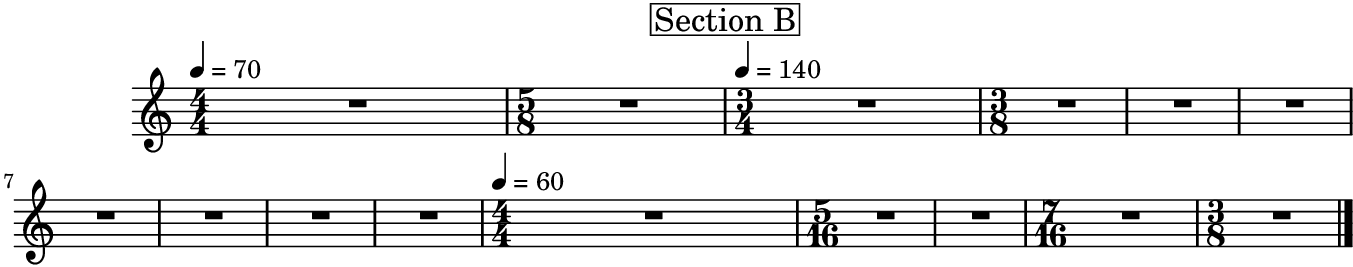

In [3]:
scorestruct.show()

A `ScoreStruct` can be exported to multiple formats: **musicxml, MIDI, pdf, png, lilypond**. For example, by saving it as MIDI it is possible to import the score structure in a DAW

In [4]:
scorestruct.write('struct.mid')

This is how the exported MIDI file looks in MuseScore. **NB**: *A note is added to the last measure of the score because an empty score is not imported correctly in many applications*

![](assets/scorestruct-export-midi-musescore.png)

## Content / Structure

As said before, the score structure defines the time signatures and tempi of the measures in a score. The same content can be represented using different score structures. In the example below a score structure is created and used as ad-hoc context. The second call to `.show` is outside the context and the default score structure is used

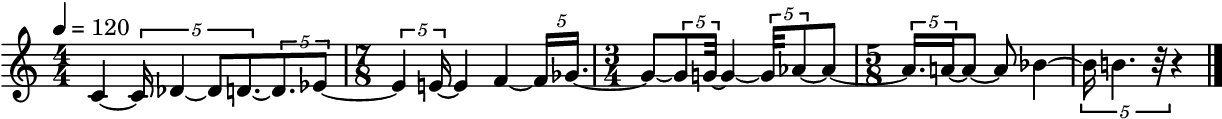

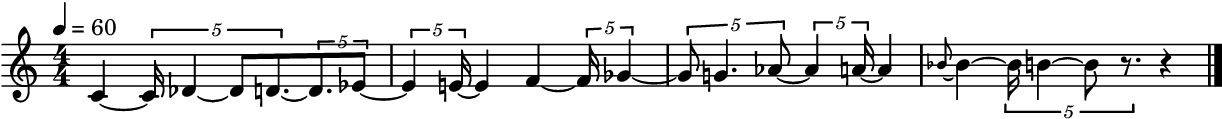

In [5]:
getConfig()['quant.complexity'] = 'highest'

scorestruct = ScoreStruct(r'''
4/4, 120
7/8
3/4
5/8(2-3)  # It is possible to set the internal subdivisions
5/8(3-2)

...
''')
notes = Chain([Note(m, dur=6/5) for i, m in enumerate(range(60, 72))])

# Used as a context manager, the workspace is temporary: the previous
# workspace is restored after the context manager exits
with scorestruct:
    notes.show()

notes.show()

Chain([4C:1.333♩, 4C#:1.333♩, 4D:1.333♩, 4D#:1.333♩, 4E:1.333♩, 4F:1.333♩, 4F#:1.333♩, 4G:1.333♩, 4G#:1.333♩, 4A:1.333♩, …])
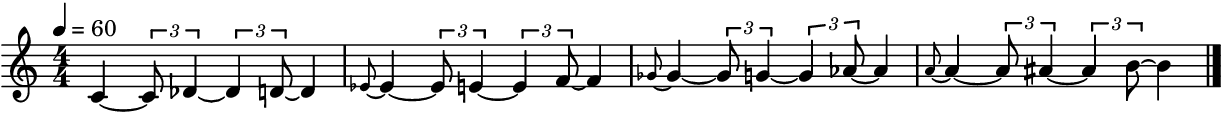

In [6]:
notes = Chain([Note(m, dur=4/3) for i, m in enumerate(range(60, 72))])
notes

Same content, two different score structures. In the next example only the tempo is modified. The resulting notation is the same, because objects in *maelzel.core* define their start time and duration in terms of beats (quarternotes). The playback is of course modified 

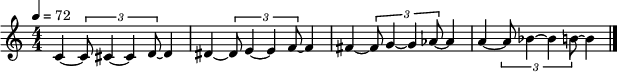

OfflineRenderer(sr=44100)
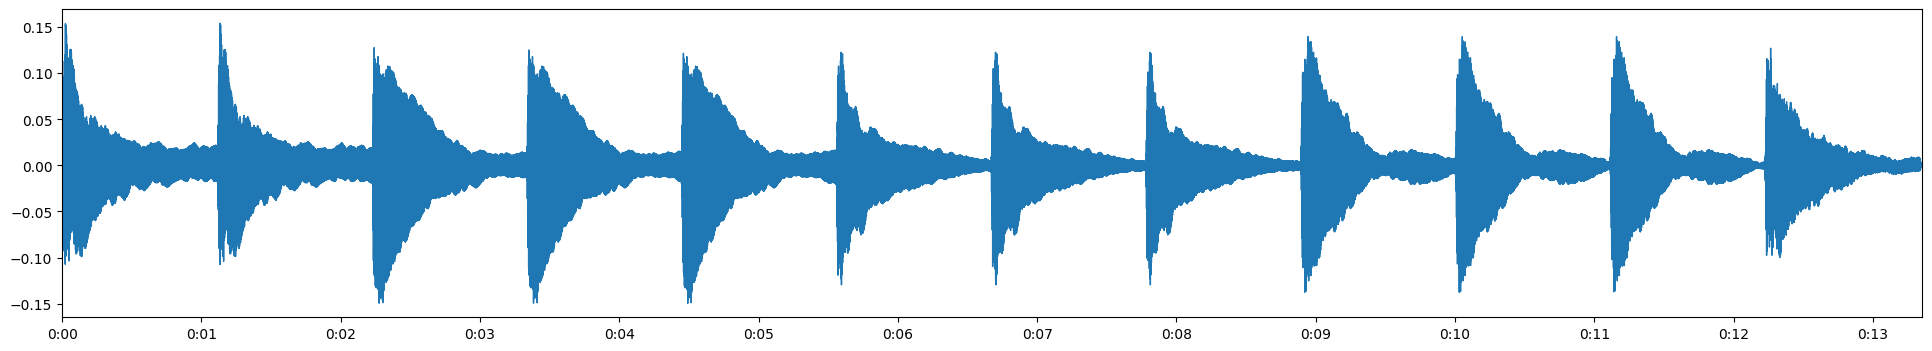

In [11]:

with ScoreStruct(timesig='4/4', tempo=72):
    notes.show()
    display(notes.rec(nchnls=1))


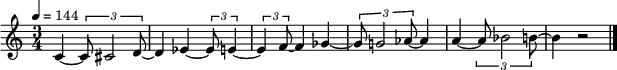

OfflineRenderer(sr=44100)
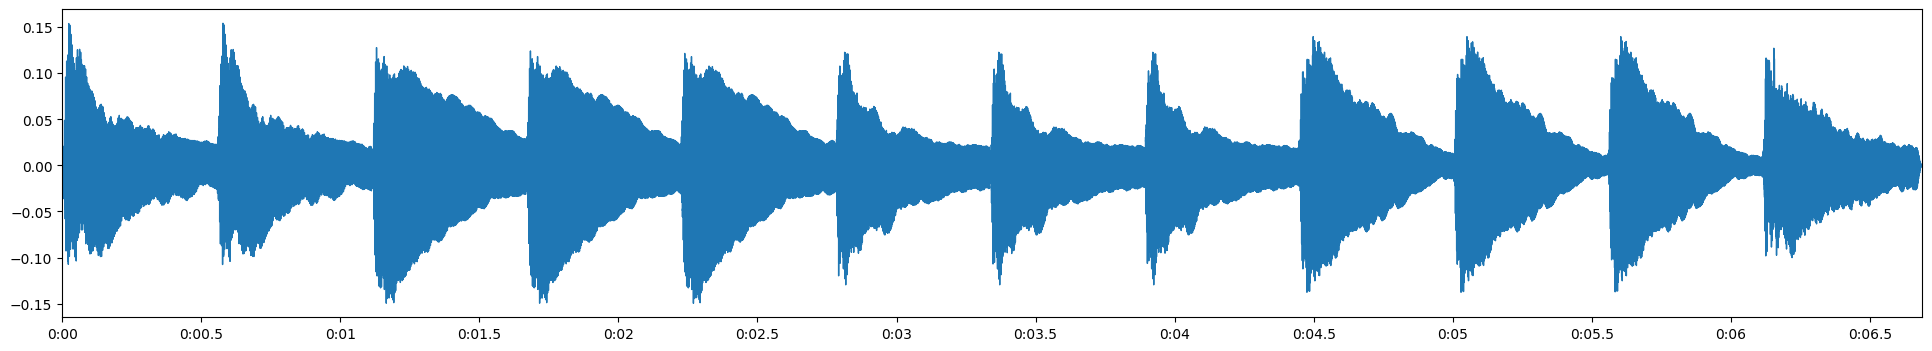

In [13]:
struct2 = ScoreStruct(timesig='3/4', tempo=144)
notes.show(scorestruct=struct2)
with struct2:
    display(notes.rec(nchnls=1))

## The Active ScoreStruct

While working on a specific musical task it is possible to set a given `ScoreStruct` as **active**, meaning that any subsequent action needed a scorestruct parameter (`.show`, `.play`, etc) will use that as default if not specified. 

In [14]:
setScoreStruct(struct2)

This modifies the active Workspace to use the given scorestruct and is in fact a shortcut to:

```python
getWorkspace().scorestruct = struct2
```

Now it is not needed to specify the `scorestruct` param

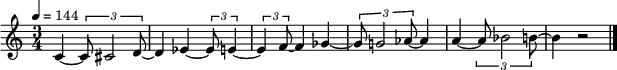

In [15]:
notes.show()

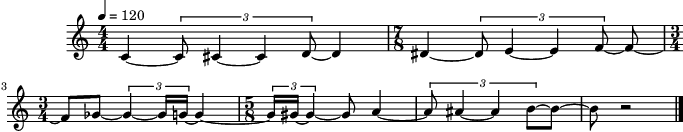

OfflineRenderer(sr=44100)
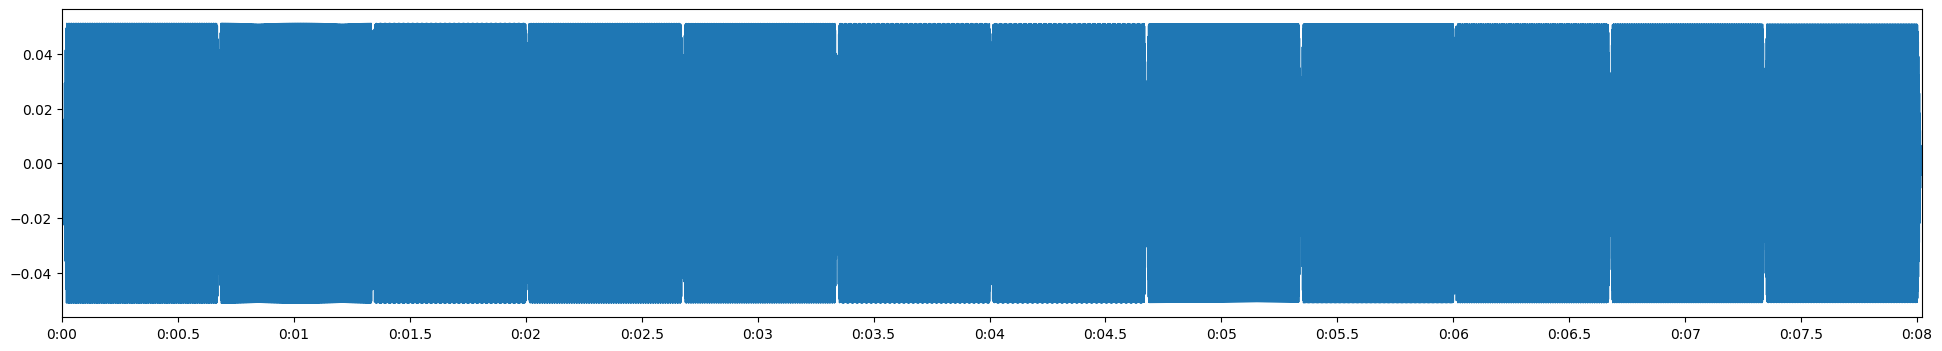

In [16]:
with Workspace(scorestruct=scorestruct, updates={'A4': 500}):
    notes.show()
    display(notes.rec(nchnls=1, instr='tri', gain=0.1))


After exiting the context manager the previous Workspace is restored

Chain([4C:1.333♩, 4C#:1.333♩, 4D:1.333♩, 4D#:1.333♩, 4E:1.333♩, 4F:1.333♩, 4F#:1.333♩, 4G:1.333♩, 4G#:1.333♩, 4A:1.333♩, …])
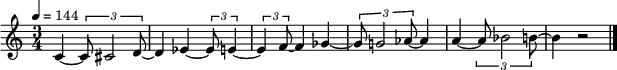

In [17]:
notes

## Creating a click track from a ScoreStruct 

It is possible to create a **click track** for any defined ScoreStruct

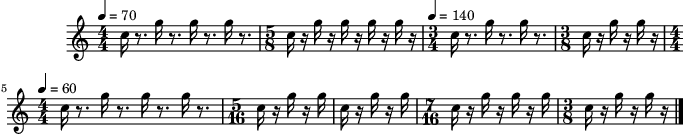

OfflineRenderer(sr=44100)
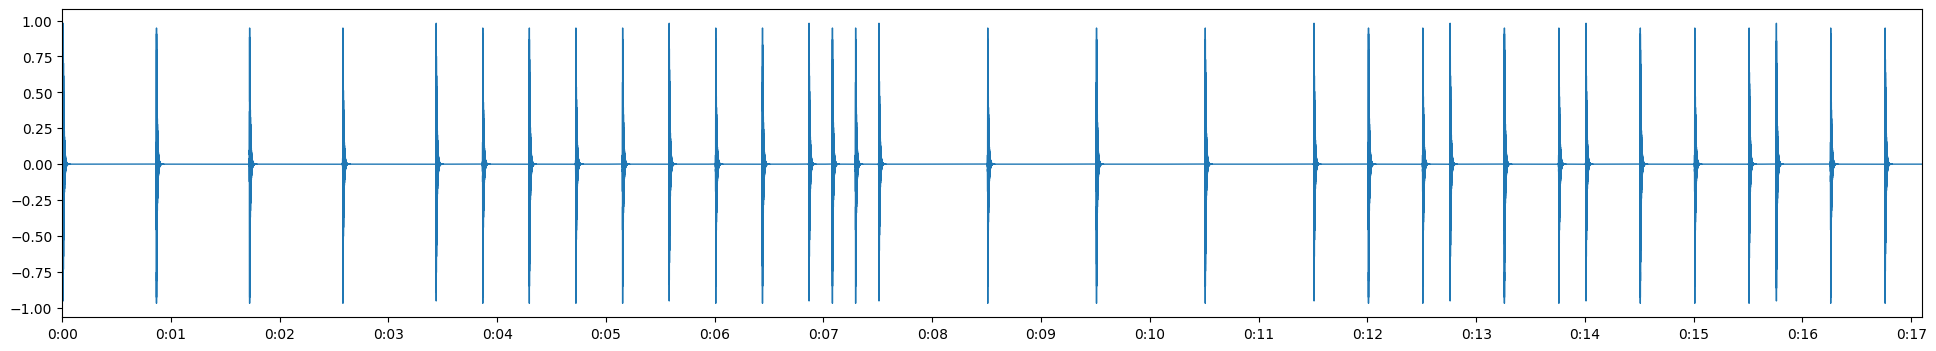

In [18]:
scorestruct = ScoreStruct(r'''
4/4, 70
5/8
3/4, 140
3/8
4/4, 60
5/16
.
7/16
3/8
...
''')

clicktrack = scorestruct.makeClickTrack(clickdur=0.25)
clicktrack.show()
clicktrack.rec(nchnls=1)


## Exporting

Both the clicktrack and the scorestruct can be exported to many formats: **musicxml**, **MIDI**, **pdf**, **png**, **lilypond**

In [10]:
clicktrack.write('clicktrack.xml')


The clicktrack imported in MuseScore

![](assets/clicktrack-export-musescore.png)

It is also possible to convert a ScoreStruct to music21

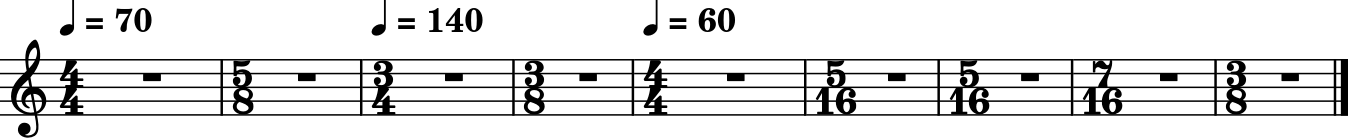

In [19]:
m21stream = scorestruct.asMusic21()

# This renders via music21, which itself calls MuseScore to convert musicxml to pdf
m21stream.show()

------

## Musical time vs Real time

To place a musical event at a specific moment in real time (time in seconds, not in quarter notes), use 
the ScoreStruct to convert between both domains.

* **beat**: returns the beat in quarternotes corresponding to the given time in seconds
* **beatDelta**: returns a duration in quarternotes corresponding to the elapsed time between the two given times in seconds

4G:2♩:offset=8
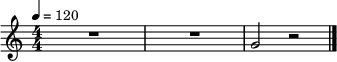

In [29]:
# Create a one second event starting at 4 seconds
setScoreStruct(tempo=120)
s = getScoreStruct()
Note("4G", offset=s.beat(4), dur=s.beatDelta(4, 5))

The same but with another tempo

4G:1.5♩:offset=6
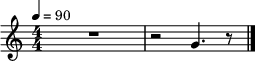

In [30]:
setTempo(90)
Note("4G", offset=s.beat(4), dur=s.beatDelta(4, 5))